# Time Series
## Introduction
Until now, the only sequence data we’ve covered have been text data, such as the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. You will now use weather time-series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. We will carefully go through an example presented by F. Chollet in his book Deep Learning with Python and compare how different types of networks solve the time-series prediction problem.

### Download data
In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical time-series. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worths of data points) and predicts the air temperature 24 hours in the future.

Download data from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

Extract data to one of your directories, load them and check if they are correct.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = open('jena_climate_2009_2016.csv', 'r')
file = open('jena_climate_2009_2016.csv', 'r')
data = file.read()
file.close()
 
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? You’ll use the following parameter values:

* lookback = 720 — Observations will go back 5 days.
* steps = 6 — Observations will be sampled at one data point per hour.
* delay = 144 — Targets will be 24 hours in the future.


### Explore dataset
To get started, you need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, the temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.
* Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data. You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

First, parse the data:

In [3]:
import numpy as np
 
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


As we are interested only in the temperature, extract it from the whole set of 14 variables. To understand the problem better you can plot the whole series or some specific parts of it:

In [4]:
column_names = ["p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"]

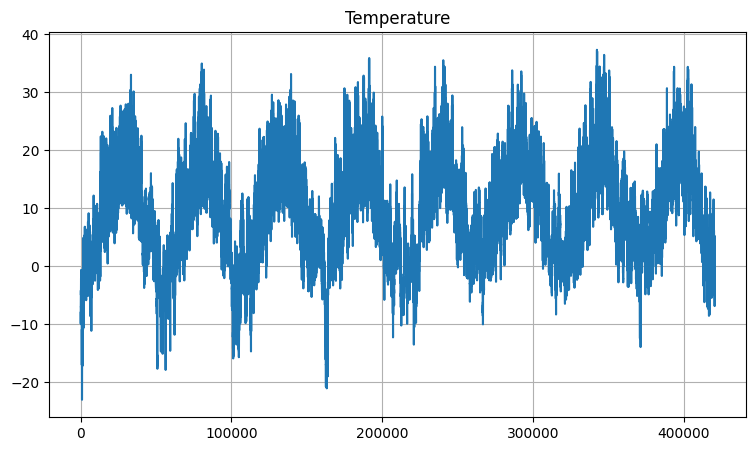

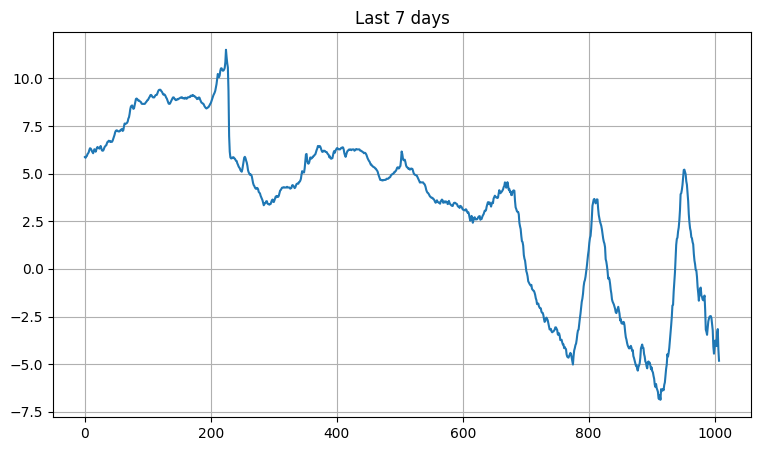

In [5]:
temp = float_data[:, 1]
 
#TODO: Plot whole temperature series, notice yearly trends
plt.figure(figsize=(9, 5))
plt.plot(temp)
plt.title("Temperature")
plt.grid()
 
#TODO: Plot the first few days
num_of_days = 7
num_of_hours = 24
num_of_samples_per_hour = 6
plt.figure(figsize=(9, 5))
plt.plot(temp[-(num_of_samples_per_hour*num_of_hours*num_of_days):])
plt.title("Last 7 days")
plt.grid()

Normalize the data by subtracting the mean and dividing by the standard deviation (calculated on a train set (first 200000 samples)):

In [6]:
#TODO: Normalize the data
float_data = (float_data - np.mean(float_data, axis=0)) / np.std(float_data[:20000, :], axis=0)

The normalization should be done for all 14 variables independently, not only for temperature. We predict only one parameter (target - y), but analyse all of them (input - x).

### Set up data generators
Now, let’s use the abstract generator function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [7]:
# generator function used to feed the training, validation and test data
 
def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
 
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Let's now define lookback, step, delay parameters and set generators. In the example, batch_size = 128 was used, but you can try with different values.

In [9]:
#TODO Define lookback, step, delay and batch size variable
lookback = 1440
step = 6
delay = 144
batch_size = 128
 
train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
 
#TODO: Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:
 
val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)
 
#TODO: Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:
 
test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=400000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

Useful info (last update on 20.12.2023):

You should expect a loss value in range 0,2-0,4 for both training and validation. 0,4 is quite bad. 0,3 is ok. 0,2 on a training set means overfitting, on validation it will be almost impossible to get.
You should expect a huge overfitting. Some results won't be good at all - validation will not improve in some cases.
The best results will probably come from a GRU layers with added dropout.
The fastest training should be achieved with conv1D

Make sure to set a steps_per_epoch and validation_step parameters. Some keras functions like ImageDataGenerator allow for skipping this parameter and set it automatically. However, in this task we have our own generator which will run indefinitely if we do not stop it.
Make sure to normalize the data for each variable, not only for a temperature.
Make sure to shuffle data only in a train generator.
In some cases specifying a batch_size twice (in a generator and in model.fit) might cause an error.
You should not see any regular oscilations in the validation loss. Such behaviour on the loss plot indicates some errors. Possibly with steps_per_epoch parameter.

### Basic approach
We will start with a basic approach that uses no recurrent layers. It probably won't work well, but will serve as a reference point. The following section shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

In [10]:
from keras import models
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [9]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
 
model.compile(optimizer=RMSprop(), loss='mae')
 
# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)//batch_size 
 
#TODO: Train the network for about 20 epochs
history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=20,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/20
500/500 [==============================] - 8s 15ms/step - loss: 1.6752 - val_loss: 0.8879
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.5258 - val_loss: 0.4176
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3426 - val_loss: 0.3598
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3149 - val_loss: 0.3672
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3007 - val_loss: 0.3537
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2886 - val_loss: 0.3585
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2824 - val_loss: 0.3729
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2747 - val_loss: 0.3807
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2660 - val_loss: 0.4272
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2641 - val_lo

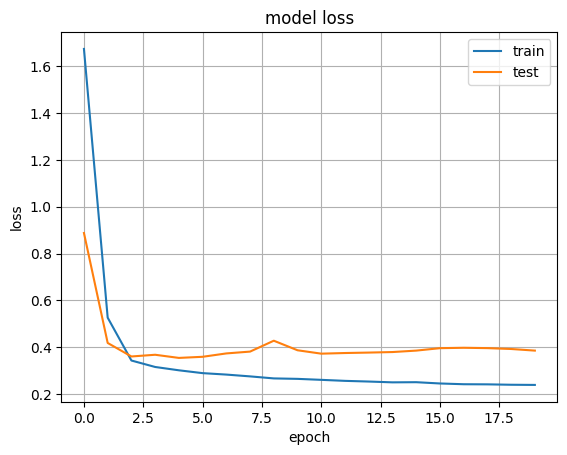

In [11]:
#TODO: Plot the results
history_dict = history.history
history_dict.keys()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

### GRU layer
Instead of the LSTM layer introduced in the previous lab, you’ll use the GRU layer, developed by Chung et al. in 2014. Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM).

In [11]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [13]:
val_steps = (300000 - 200001 - lookback)//batch_size 

history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=20,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/40


500/500 [==============================] - 43s 84ms/step - loss: 0.3461 - val_loss: 0.3161
Epoch 2/40
500/500 [==============================] - 41s 83ms/step - loss: 0.3296 - val_loss: 0.3158
Epoch 3/40
500/500 [==============================] - 40s 81ms/step - loss: 0.3215 - val_loss: 0.3058
Epoch 4/40
240/500 [=============>................] - ETA: 14s - loss: 0.3153

KeyboardInterrupt: 

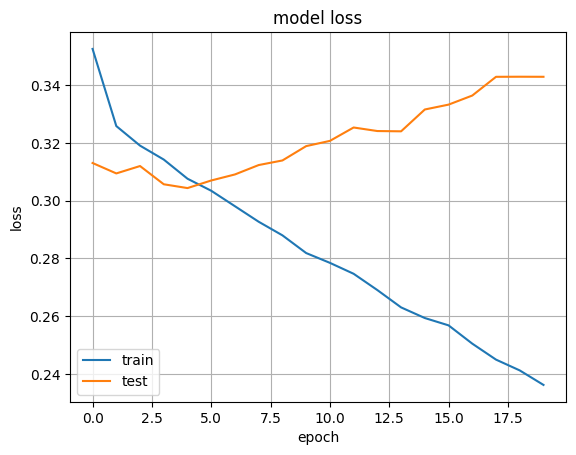

In [16]:
#TODO: Plot the results
history_dict = history.history
history_dict.keys()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Train this network for about 20 epochs and plot the results.

You can also try stacking several GRU layers on each other, or adding dropout and recurrent dropout to the GRU layer. In this case train it a bit longer (aboout 40 epochs):

In [14]:
model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

val_steps = (300000 - 200001 - lookback)//batch_size 

In [15]:
history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=40,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/40


500/500 [==============================] - 70s 137ms/step - loss: 0.3847 - val_loss: 0.3272
Epoch 2/40
500/500 [==============================] - 68s 137ms/step - loss: 0.3555 - val_loss: 0.3187
Epoch 3/40
500/500 [==============================] - 65s 131ms/step - loss: 0.3478 - val_loss: 0.3173
Epoch 4/40
500/500 [==============================] - 64s 128ms/step - loss: 0.3430 - val_loss: 0.3187
Epoch 5/40
500/500 [==============================] - 64s 128ms/step - loss: 0.3395 - val_loss: 0.3150
Epoch 6/40
500/500 [==============================] - 65s 129ms/step - loss: 0.3360 - val_loss: 0.3154
Epoch 7/40
500/500 [==============================] - 64s 128ms/step - loss: 0.3302 - val_loss: 0.3169
Epoch 8/40
500/500 [==============================] - 68s 137ms/step - loss: 0.3262 - val_loss: 0.3141
Epoch 9/40
500/500 [==============================] - 65s 130ms/step - loss: 0.3230 - val_loss: 0.3215
Epoch 10/40
500/500 [==============================] - 64s 128ms/step - loss: 0.3204

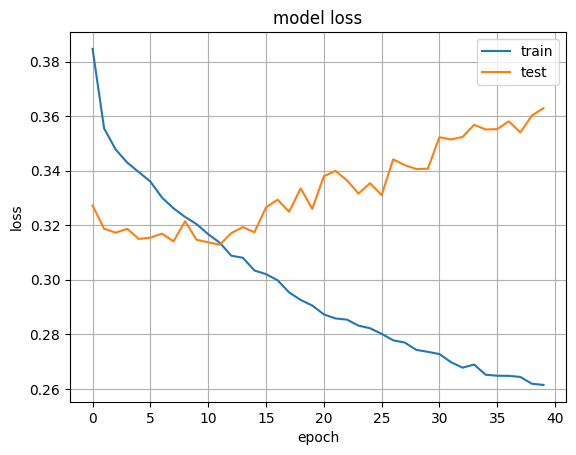

In [16]:
history_dict = history.history
history_dict.keys()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

### Bidirectional GRU layer
A bidirectional recurrent neural network exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

In [17]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


In [18]:
history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=20,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/20
500/500 [==============================] - 56s 107ms/step - loss: 0.3450 - val_loss: 0.3122
Epoch 2/20
500/500 [==============================] - 53s 106ms/step - loss: 0.3189 - val_loss: 0.3177
Epoch 3/20
500/500 [==============================] - 53s 105ms/step - loss: 0.3103 - val_loss: 0.3120
Epoch 4/20
500/500 [==============================] - 53s 105ms/step - loss: 0.3042 - val_loss: 0.3107
Epoch 5/20
500/500 [==============================] - 53s 105ms/step - loss: 0.2964 - val_loss: 0.3134
Epoch 6/20
500/500 [==============================] - 53s 105ms/step - loss: 0.2889 - val_loss: 0.3146
Epoch 7/20
500/500 [==============================] - 52s 104ms/step - loss: 0.2825 - val_loss: 0.3155
Epoch 8/20
500/500 [==============================] - 52s 105ms/step - loss: 0.2727 - val_loss: 0.3255
Epoch 9/20
500/500 [==============================] - 52s 105ms/step - loss: 0.2622 - val_loss: 0.3310
Epoch 10/20
500/500 [==============================] - 53s 105ms/step - l

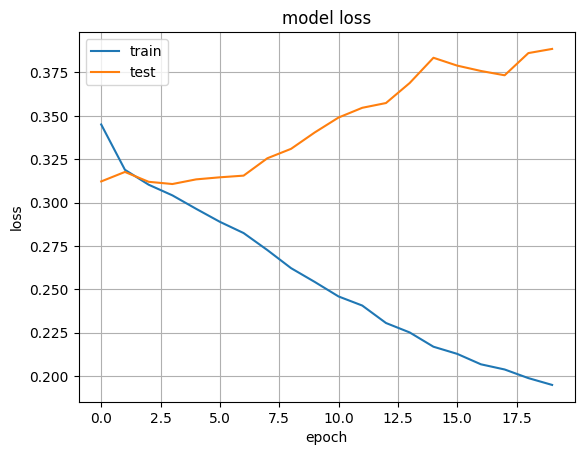

In [19]:
history_dict = history.history
history_dict.keys()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()

Try training bidirectional GRU for about 40 epochs, but don't expect much improvement vs simple GRU. In this example reversing data order does not carry much information, but keep in mind that this is possible and might sometimes be useful.

### Conv1D layers
ConvNets, we worked on before, extracted local features and allow for representation modularity. The same properties that make them excel at computer vision also make them highly relevant to sequence processing. They can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost.
2D convolution layers extract patches from image tensors and apply an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized in a different position.

In [23]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

Train this network for about 20 epochs.

This lab was based on the book Deep Learning with Python by F.Chollet. Fragments of the code (with some modifications) are available also in the this Notebook, Tensorflow Website, or Keras Website.

In [24]:
history = model.fit(
      train_gen,
      steps_per_epoch=500,
      epochs=20,
      validation_data=val_gen,
      validation_steps=val_steps,
      batch_size=batch_size)

Epoch 1/20


500/500 [==============================] - 37s 70ms/step - loss: 0.3924 - val_loss: 0.3508
Epoch 2/20
500/500 [==============================] - 34s 69ms/step - loss: 0.3523 - val_loss: 0.3906
Epoch 3/20
500/500 [==============================] - 34s 68ms/step - loss: 0.3315 - val_loss: 0.3367
Epoch 4/20
500/500 [==============================] - 34s 68ms/step - loss: 0.3198 - val_loss: 0.3451
Epoch 5/20
500/500 [==============================] - 34s 68ms/step - loss: 0.3099 - val_loss: 0.3592
Epoch 6/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2992 - val_loss: 0.3528
Epoch 7/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2919 - val_loss: 0.3582
Epoch 8/20
500/500 [==============================] - 35s 70ms/step - loss: 0.2834 - val_loss: 0.3707
Epoch 9/20
500/500 [==============================] - 35s 70ms/step - loss: 0.2778 - val_loss: 0.3611
Epoch 10/20
500/500 [==============================] - 35s 70ms/step - loss: 0.2698 - val_los

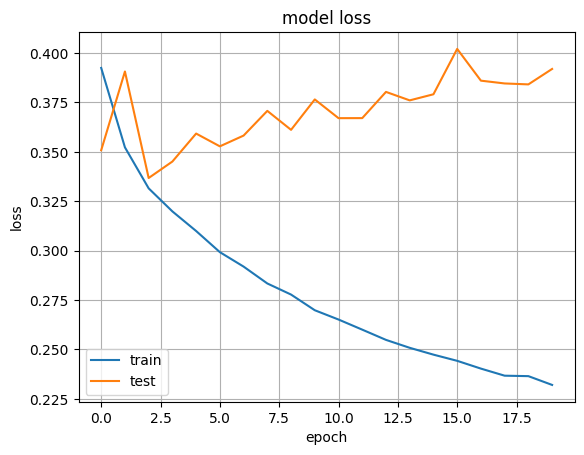

In [25]:
history_dict = history.history
history_dict.keys()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.grid()
plt.show()